<a href="https://colab.research.google.com/github/indweller/gamengen-wm/blob/Mario-GPT/Mario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/aravinds-kannappan/MarioGPT.git

Cloning into 'MarioGPT'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 132 (delta 40), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (132/132), 133.94 KiB | 3.52 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [ ]:
#!/usr/bin/env python3
"""
HMM-DDA Complete Run Pipeline
Unified script that imports and orchestrates all src/ and scripts/ modules.

Usage:
    python run_pipeline.py [--skip-calibration] [--episodes N] [--device cpu|cuda]

Requires: src/ and scripts/ folders in the same directory
"""

import sys
from pathlib import Path

# Adjust this if needed
PROJECT_ROOT = Path("/content/MarioGPT")  # Colab example
# PROJECT_ROOT = Path.cwd()               # if notebook is in root

sys.path.insert(0, str(PROJECT_ROOT))

print("Project root added:", PROJECT_ROOT)


import numpy as np
from collections import deque, Counter
from tqdm import tqdm

# ============================================================================
# IMPORTS FROM src/ MODULES
# ============================================================================
from src.mario_env import MarioEnvWrapper, MarioGridEnv
from src.level_generator import LevelGenerator
from src.hmm_controller import HMM_DDA
from src.metrics_collector import MetricsCollector
from src.t_score import (
    compute_T_score,
    compute_T_score_from_metrics,
    get_metric_contributions,
    interpret_T_score
)
from src.utils import (
    Logger,
    set_random_seeds,
    check_cuda,
    load_config,
    save_config,
    normalize_value,
    denormalize_value,
    plot_learning_curve,
    plot_belief_evolution,
    plot_state_distribution,
    plot_metrics_comparison,
    plot_t_score_distributions,
    plot_state_transition_diagram,
)

# ============================================================================
# IMPORTS FROM scripts/ MODULES
# ============================================================================
from scripts.calibrate import (
    HeuristicAgent,
    GymEnvWrapper,
    create_ppo_agent,
    train_baseline_agent,
    collect_calibration_data,
)

from scripts.derive_parameters import (
    load_calibration_data,
    compute_normalization_bounds,
    compute_t_scores_for_episodes,
    fit_gaussian_distributions,
    derive_thresholds,
    optimize_metric_weights,
    create_transition_matrix,
    visualize_distributions,
)

from scripts.train import (
    CONFIG as TRAIN_CONFIG,
    HeuristicAgent as TrainHeuristicAgent,
    AdaptiveEnv,
    create_ppo_agent as create_train_ppo_agent,
    run_episode,
)

from scripts.evaluate import (
    load_training_data,
    compute_metrics_by_state,
    generate_visualizations,
    print_summary_statistics,
)

# Check SB3 availability
try:
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv
    SB3_AVAILABLE = True
except ImportError:
    SB3_AVAILABLE = False

# ============================================================================
# CONFIGURATION
# ============================================================================

PIPELINE_CONFIG = {
    'total_episodes': 1000,
    'calibration_episodes_per_difficulty': 50,
    'baseline_training_episodes': 200,
    'hmm_update_frequency': 10,
    'metrics_window': 10,
    'checkpoint_frequency': 500,
    'log_frequency': 50,
    'max_steps_per_episode': 2000,
    'adaptation_frequency': 500,
    'train_freq': 10,
    'train_timesteps': 2048,
    'seed': 42,
}

# ============================================================================
# PHASE 1: CALIBRATION (using scripts/calibrate.py)
# ============================================================================

def phase1_calibration(generator: LevelGenerator, device: str, config: dict, output_dir: Path):
    """
    Phase 1: Calibration
    Imports and uses functions from scripts/calibrate.py:
      - train_baseline_agent()
      - collect_calibration_data()
      - HeuristicAgent, GymEnvWrapper, create_ppo_agent
    """
    print("\n" + "=" * 60)
    print("PHASE 1: CALIBRATION")
    print("Using: scripts/calibrate.py")
    print("  - train_baseline_agent()")
    print("  - collect_calibration_data()")
    print("=" * 60)

    calibration_dir = output_dir / 'calibration_data'
    calibration_dir.mkdir(parents=True, exist_ok=True)

    # Step 1: Train baseline agent using calibrate.train_baseline_agent
    print("\nStep 1.1: Calling train_baseline_agent() from scripts/calibrate.py...")
    agent = train_baseline_agent(
        generator=generator,
        n_episodes=config['baseline_training_episodes'],
        device=device
    )

    # Step 2: Collect calibration data using calibrate.collect_calibration_data
    print("\nStep 1.2: Calling collect_calibration_data() from scripts/calibrate.py...")
    calibration_results = {}

    for difficulty in ['Low', 'Transition', 'High']:
        df = collect_calibration_data(
            agent=agent,
            generator=generator,
            difficulty_name=difficulty,
            n_episodes=config['calibration_episodes_per_difficulty']
        )

        # Save to CSV
        csv_path = calibration_dir / f'{difficulty.lower()}_metrics.csv'
        df.to_csv(csv_path, index=False)
        calibration_results[difficulty] = df

        print(f"  {difficulty}: CR={df['completed'].mean():.2%}, Deaths={df['deaths'].mean():.2f}")

    print(f"\nCalibration data saved to {calibration_dir}")
    return calibration_results, agent


# ============================================================================
# PHASE 2: PARAMETER DERIVATION (using scripts/derive_parameters.py)
# ============================================================================

def phase2_derive_parameters(calibration_dir: Path, output_dir: Path):
    """
    Phase 2: Parameter Derivation
    Imports and uses functions from scripts/derive_parameters.py:
      - load_calibration_data()
      - compute_normalization_bounds()
      - optimize_metric_weights()
      - compute_t_scores_for_episodes()
      - fit_gaussian_distributions()
      - derive_thresholds()
      - create_transition_matrix()
      - visualize_distributions()
    """
    print("\n" + "=" * 60)
    print("PHASE 2: PARAMETER DERIVATION")
    print("Using: scripts/derive_parameters.py")
    print("  - load_calibration_data()")
    print("  - compute_normalization_bounds()")
    print("  - optimize_metric_weights()")
    print("  - fit_gaussian_distributions()")
    print("  - derive_thresholds()")
    print("  - create_transition_matrix()")
    print("=" * 60)

    config_dir = output_dir / 'config'
    figures_dir = output_dir / 'figures' / 'calibration'
    config_dir.mkdir(parents=True, exist_ok=True)
    figures_dir.mkdir(parents=True, exist_ok=True)

    # Step 2.1: Load calibration data
    print("\nStep 2.1: Calling load_calibration_data()...")
    data = load_calibration_data(calibration_dir)

    # Step 2.2: Compute normalization bounds
    print("\nStep 2.2: Calling compute_normalization_bounds()...")
    normalization = compute_normalization_bounds(data)
    save_config(normalization, str(config_dir / 'normalization_bounds.json'))

    # Step 2.3: Optimize metric weights
    print("\nStep 2.3: Calling optimize_metric_weights()...")
    weights = optimize_metric_weights(data, normalization)
    save_config({'weights': weights}, str(config_dir / 'metric_weights.json'))

    # Step 2.4: Compute T-scores
    print("\nStep 2.4: Calling compute_t_scores_for_episodes()...")
    t_scores = compute_t_scores_for_episodes(data, weights, normalization)
    for diff, scores in t_scores.items():
        print(f"  {diff}: mean={np.mean(scores):.3f}, std={np.std(scores):.3f}")

    # Step 2.5: Fit emission distributions
    print("\nStep 2.5: Calling fit_gaussian_distributions()...")
    emissions = fit_gaussian_distributions(t_scores)
    save_config(emissions, str(config_dir / 'emission_params.json'))

    # Step 2.6: Derive thresholds
    print("\nStep 2.6: Calling derive_thresholds()...")
    thresholds = derive_thresholds(emissions)
    save_config(thresholds, str(config_dir / 'thresholds.json'))

    # Step 2.7: Create transition matrix
    print("\nStep 2.7: Calling create_transition_matrix()...")
    transition_matrix = create_transition_matrix()
    save_config(transition_matrix, str(config_dir / 'transition_matrix.json'))

    # Step 2.8: Save prompts
    prompts = {
        'Low': "few enemies, no gaps, many pipes, low elevation, easy",
        'Transition': "varied challenges, mixed density, skill assessment",
        'High': "many enemies, many gaps, few pipes, high elevation, hard"
    }
    save_config(prompts, str(config_dir / 'prompts.json'))

    # Step 2.9: Visualize
    print("\nStep 2.8: Calling visualize_distributions()...")
    visualize_distributions(t_scores, emissions, figures_dir)

    print(f"\nParameters saved to {config_dir}")

    return {
        'weights': weights,
        'normalization': normalization,
        'emissions': emissions,
        'thresholds': thresholds,
        'transition_matrix': transition_matrix,
    }


# ============================================================================
# PHASE 3: TRAINING (using scripts/train.py and src/ modules)
# ============================================================================

def phase3_training(generator: LevelGenerator, device: str, config: dict,
                    output_dir: Path, derived_params: dict):
    """
    Phase 3: Training with HMM-DDA
    Imports and uses from scripts/train.py:
      - TRAIN_CONFIG
      - AdaptiveEnv
      - create_ppo_agent()
      - run_episode()

    Also uses from src/:
      - HMM_DDA (src/hmm_controller.py)
      - MetricsCollector (src/metrics_collector.py)
      - compute_T_score (src/t_score.py)
      - Logger (src/utils.py)
    """
    print("\n" + "=" * 60)
    print("PHASE 3: TRAINING WITH HMM-DDA")
    print("Using: scripts/train.py")
    print("  - AdaptiveEnv")
    print("  - create_ppo_agent()")
    print("  - run_episode()")
    print("Using: src/hmm_controller.py")
    print("  - HMM_DDA")
    print("Using: src/metrics_collector.py")
    print("  - MetricsCollector")
    print("Using: src/t_score.py")
    print("  - compute_T_score()")
    print("=" * 60)

    checkpoint_dir = output_dir / 'checkpoints'
    log_dir = output_dir / 'logs'
    config_dir = output_dir / 'config'

    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    log_dir.mkdir(parents=True, exist_ok=True)

    # Build T-score config for src/t_score.py
    t_score_config = {
        'weights': derived_params['weights'],
        'normalization': derived_params['normalization']
    }

    # Initialize HMM_DDA from src/hmm_controller.py
    print("\nInitializing HMM_DDA from src/hmm_controller.py...")
    config_path = str(config_dir) if (config_dir / 'transition_matrix.json').exists() else None
    hmm = HMM_DDA(config_path)
    print(f"  {hmm}")

    # Initialize AdaptiveEnv from scripts/train.py
    print("\nInitializing AdaptiveEnv from scripts/train.py...")
    env = AdaptiveEnv(generator, hmm)

    # Create agent using scripts/train.py create_ppo_agent
    print(f"\nCalling create_ppo_agent() from scripts/train.py (SB3: {SB3_AVAILABLE})...")
    agent = create_train_ppo_agent(env, device, TRAIN_CONFIG.get('ppo_config'))

    # Initialize MetricsCollector from src/metrics_collector.py
    print("\nInitializing MetricsCollector from src/metrics_collector.py...")
    collector = MetricsCollector(max_size=2000, window_size=config['metrics_window'])

    # Initialize Logger from src/utils.py
    print("Initializing Logger from src/utils.py...")
    logger = Logger(str(log_dir), experiment_name='hmm_dda_training')

    # Training statistics
    episode_rewards = deque(maxlen=100)
    state_counts = {'Low': 0, 'Transition': 0, 'High': 0}

    print(f"\nStarting training loop...")
    print(f"  Total episodes: {config['total_episodes']}")
    print(f"  HMM update frequency: {config['hmm_update_frequency']}")

    for episode in tqdm(range(config['total_episodes']), desc="Training"):
        # Get current state from HMM_DDA
        current_state = hmm.get_current_state()
        state_counts[current_state] += 1

        # Run episode using scripts/train.py run_episode()
        metrics = run_episode(env, agent, max_steps=config['max_steps_per_episode'])

        # Add to MetricsCollector from src/metrics_collector.py
        collector.add_episode(metrics)
        episode_rewards.append(metrics['reward'])

        # Update HMM periodically using src/t_score.py compute_T_score
        if (episode + 1) % config['hmm_update_frequency'] == 0:
            if len(collector) >= config['metrics_window']:
                # Compute T-score using src/t_score.py
                T = compute_T_score(collector, t_score_config, window=config['metrics_window'])

                # Update HMM belief using src/hmm_controller.py
                new_state = hmm.update(T)
                belief = hmm.get_belief()

                if new_state != current_state or (episode + 1) % config['log_frequency'] == 0:
                    log_data = {
                        'episode': episode + 1,
                        'state': new_state,
                        'prev_state': current_state,
                        'belief_low': float(belief[0]),
                        'belief_transition': float(belief[1]),
                        'belief_high': float(belief[2]),
                        'T_score': float(T),
                        'reward': float(metrics['reward']),
                        'avg_reward_100': float(np.mean(episode_rewards)),
                        'completed': bool(metrics['completed']),
                        'deaths': int(metrics['deaths']),
                        'max_x': float(metrics['max_x']),
                        'completion_rate': collector.get_completion_rate(),
                    }
                    # Log using src/utils.py Logger
                    logger.log(log_data, print_console=(episode + 1) % config['log_frequency'] == 0)

        # Train PPO agent
        if SB3_AVAILABLE and (episode + 1) % config['train_freq'] == 0:
            agent.learn(total_timesteps=config['train_timesteps'], reset_num_timesteps=False)

        # Checkpoint
        if (episode + 1) % config['checkpoint_frequency'] == 0:
            # Save HMM state using src/hmm_controller.py
            hmm.save_state(str(checkpoint_dir / f'hmm_{episode+1}.json'))
            if SB3_AVAILABLE:
                agent.save(str(checkpoint_dir / f'ppo_{episode+1}'))
            # Save metrics using src/metrics_collector.py
            collector.save_to_csv(str(checkpoint_dir / f'metrics_{episode+1}.csv'))

            print(f"\n[Checkpoint {episode+1}]")
            print(f"  State: {hmm.get_current_state()}, Belief: {hmm.get_belief().round(3)}")
            print(f"  Avg Reward: {np.mean(episode_rewards):.2f}, CR: {collector.get_completion_rate():.2%}")

        # Adapt HMM using src/hmm_controller.py
        if (episode + 1) % config['adaptation_frequency'] == 0:
            hmm.adapt_transition_matrix()

    # Final save
    hmm.save_state(str(checkpoint_dir / 'hmm_final.json'))
    if SB3_AVAILABLE:
        agent.save(str(checkpoint_dir / 'ppo_final'))
    logger.save_metrics()
    collector.save_to_csv(str(checkpoint_dir / 'metrics_final.csv'))

    env.close()

    print(f"\nTraining complete. Checkpoints saved to {checkpoint_dir}")

    return {
        'hmm': hmm,
        'collector': collector,
        'state_counts': state_counts,
        'final_avg_reward': float(np.mean(episode_rewards)),
        'checkpoint_dir': checkpoint_dir,
        'log_dir': log_dir,
    }


# ============================================================================
# PHASE 4: EVALUATION (using scripts/evaluate.py and src/utils.py)
# ============================================================================

def phase4_evaluation(training_results: dict, output_dir: Path):
    """
    Phase 4: Evaluation
    Imports and uses from scripts/evaluate.py:
      - load_training_data()
      - compute_metrics_by_state()
      - generate_visualizations()
      - print_summary_statistics()

    Also uses from src/utils.py:
      - plot_learning_curve()
      - plot_belief_evolution()
      - plot_state_distribution()
    """
    print("\n" + "=" * 60)
    print("PHASE 4: EVALUATION")
    print("Using: scripts/evaluate.py")
    print("  - load_training_data()")
    print("  - compute_metrics_by_state()")
    print("  - generate_visualizations()")
    print("  - print_summary_statistics()")
    print("Using: src/utils.py")
    print("  - plot_learning_curve()")
    print("  - plot_belief_evolution()")
    print("  - plot_state_distribution()")
    print("=" * 60)

    figures_dir = output_dir / 'figures' / 'evaluation'
    figures_dir.mkdir(parents=True, exist_ok=True)

    checkpoint_dir = training_results['checkpoint_dir']
    log_dir = training_results['log_dir']
    hmm = training_results['hmm']
    state_counts = training_results['state_counts']

    # Load training data using scripts/evaluate.py load_training_data()
    print("\nCalling load_training_data() from scripts/evaluate.py...")
    metrics_df, hmm_data = load_training_data(checkpoint_dir, log_dir)

    # If hmm_data is empty, use the HMM from training
    if not hmm_data:
        hmm_data = {
            'state_history': hmm.state_history,
            'belief_history': [b.tolist() for b in hmm.belief_history],
            't_score_history': hmm.t_score_history,
        }

    # Compute metrics by state using scripts/evaluate.py compute_metrics_by_state()
    print("\nCalling compute_metrics_by_state() from scripts/evaluate.py...")
    metrics_by_state = compute_metrics_by_state(metrics_df, hmm_data)

    # Generate visualizations using scripts/evaluate.py generate_visualizations()
    print("\nCalling generate_visualizations() from scripts/evaluate.py...")
    generate_visualizations(metrics_df, hmm_data, figures_dir)

    # Print summary using scripts/evaluate.py print_summary_statistics()
    print("\nCalling print_summary_statistics() from scripts/evaluate.py...")
    print_summary_statistics(metrics_df, hmm_data, metrics_by_state)

    # Additional: Flow zone analysis
    if not metrics_df.empty and 'reward' in metrics_df.columns:
        rewards = metrics_df['reward'].values
        median_r = np.median(rewards)
        std_r = np.std(rewards)
        flow_min = median_r - 0.5 * std_r
        flow_max = median_r + 0.5 * std_r

        in_flow = np.sum((rewards >= flow_min) & (rewards <= flow_max))
        flow_pct = in_flow / len(rewards) * 100

        print(f"\nAdditional Flow Zone Analysis:")
        print(f"  Flow zone: [{flow_min:.1f}, {flow_max:.1f}]")
        print(f"  Episodes in flow: {in_flow}/{len(rewards)} ({flow_pct:.1f}%)")
        print(f"  Target: >60%  {'✓ ACHIEVED' if flow_pct >= 60 else '✗ Below target'}")

    print(f"\nFigures saved to {figures_dir}")


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    parser = argparse.ArgumentParser(description='HMM-DDA Complete Pipeline')
    parser.add_argument('--skip-calibration', action='store_true',
                        help='Skip calibration and use default parameters')
    parser.add_argument('--episodes', type=int, default=1000,
                        help='Number of training episodes')
    parser.add_argument('--calibration-episodes', type=int, default=50,
                        help='Calibration episodes per difficulty')
    parser.add_argument('--device', type=str, default='cpu', choices=['cpu', 'cuda'],
                        help='Device for training')
    parser.add_argument('--seed', type=int, default=42,
                        help='Random seed')
    parser.add_argument('--output-dir', type=str, default='./hmm_dda_output',
                        help='Output directory')
    args = parser.parse_args()

    print("=" * 60)
    print("HMM-DDA COMPLETE PIPELINE")
    print("=" * 60)
    print("\nImported modules:")
    print("  src/mario_env.py         -> MarioEnvWrapper, MarioGridEnv")
    print("  src/level_generator.py   -> LevelGenerator")
    print("  src/hmm_controller.py    -> HMM_DDA")
    print("  src/metrics_collector.py -> MetricsCollector")
    print("  src/t_score.py           -> compute_T_score, compute_T_score_from_metrics")
    print("  src/utils.py             -> Logger, plotting functions, etc.")
    print("  scripts/calibrate.py     -> train_baseline_agent, collect_calibration_data")
    print("  scripts/derive_parameters.py -> load_calibration_data, fit_gaussian_distributions, etc.")
    print("  scripts/train.py         -> AdaptiveEnv, run_episode, create_ppo_agent")
    print("  scripts/evaluate.py      -> load_training_data, generate_visualizations, etc.")

    # Setup using src/utils.py
    set_random_seeds(args.seed)
    cuda_available, device_name = check_cuda()
    device = args.device if args.device == 'cpu' or cuda_available else 'cpu'
    print(f"\nDevice: {device} ({device_name})")
    print(f"SB3 Available: {SB3_AVAILABLE}")

    output_dir = Path(args.output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Update config
    config = PIPELINE_CONFIG.copy()
    config['total_episodes'] = args.episodes
    config['calibration_episodes_per_difficulty'] = args.calibration_episodes

    # Save config using src/utils.py
    save_config(config, str(output_dir / 'run_config.json'))

    # Initialize LevelGenerator from src/level_generator.py
    print("\nInitializing LevelGenerator from src/level_generator.py...")
    generator = LevelGenerator(device=device)

    # ========================================================================
    # PHASE 1 & 2: Calibration and Parameter Derivation
    # ========================================================================
    if not args.skip_calibration:
        # Phase 1: Calibration (scripts/calibrate.py)
        calibration_results, baseline_agent = phase1_calibration(
            generator, device, config, output_dir
        )

        # Phase 2: Parameter Derivation (scripts/derive_parameters.py)
        calibration_dir = output_dir / 'calibration_data'
        derived_params = phase2_derive_parameters(calibration_dir, output_dir)
    else:
        print("\nSkipping calibration, using default parameters...")
        config_dir = output_dir / 'config'
        config_dir.mkdir(parents=True, exist_ok=True)

        # Default parameters
        derived_params = {
            'weights': [0.25, 0.20, 0.25, 0.15, 0.15],
            'normalization': {
                'death_rate_max': 5.0,
                'reward_trend_min': -50.0,
                'reward_trend_max': 50.0,
                'time_to_complete_max': 2000.0,
                'progress_variance_max': 500.0,
            },
            'emissions': {
                'Low': {'mu': 0.25, 'sigma': 0.15},
                'Transition': {'mu': 0.50, 'sigma': 0.12},
                'High': {'mu': 0.75, 'sigma': 0.15}
            },
            'thresholds': {'low_transition': 0.35, 'transition_high': 0.65},
            'transition_matrix': {
                'matrix': [[0.70, 0.25, 0.05], [0.20, 0.40, 0.40], [0.05, 0.25, 0.70]],
                'states': ['Low', 'Transition', 'High'],
            }
        }

        # Save using src/utils.py save_config
        save_config(derived_params['normalization'], str(config_dir / 'normalization_bounds.json'))
        save_config({'weights': derived_params['weights']}, str(config_dir / 'metric_weights.json'))
        save_config(derived_params['emissions'], str(config_dir / 'emission_params.json'))
        save_config(derived_params['thresholds'], str(config_dir / 'thresholds.json'))
        save_config(derived_params['transition_matrix'], str(config_dir / 'transition_matrix.json'))
        save_config({
            'Low': "few enemies, no gaps, many pipes, low elevation, easy",
            'Transition': "varied challenges, mixed density, skill assessment",
            'High': "many enemies, many gaps, few pipes, high elevation, hard"
        }, str(config_dir / 'prompts.json'))

    # ========================================================================
    # PHASE 3: Training (scripts/train.py + src/ modules)
    # ========================================================================
    training_results = phase3_training(generator, device, config, output_dir, derived_params)

    # ========================================================================
    # PHASE 4: Evaluation (scripts/evaluate.py + src/utils.py)
    # ========================================================================
    phase4_evaluation(training_results, output_dir)

    # ========================================================================
    # FINAL SUMMARY
    # ========================================================================
    print("\n" + "=" * 60)
    print("PIPELINE COMPLETE")
    print("=" * 60)
    print(f"\nOutput directory: {output_dir}")
    print(f"  config/           - HMM parameters (from scripts/derive_parameters.py)")
    print(f"  calibration_data/ - Calibration metrics (from scripts/calibrate.py)")
    print(f"  checkpoints/      - Model checkpoints (from scripts/train.py)")
    print(f"  logs/             - Training logs (from src/utils.py Logger)")
    print(f"  figures/          - Visualizations (from scripts/evaluate.py + src/utils.py)")

    print("\n" + "=" * 60)
    print("MODULE USAGE SUMMARY")
    print("=" * 60)
    print("\nsrc/ modules used:")
    print("  ✓ src/mario_env.py         - MarioEnvWrapper, MarioGridEnv")
    print("  ✓ src/level_generator.py   - LevelGenerator")
    print("  ✓ src/hmm_controller.py    - HMM_DDA (Bayesian updates, state tracking)")
    print("  ✓ src/metrics_collector.py - MetricsCollector (episode buffering)")
    print("  ✓ src/t_score.py           - compute_T_score, interpret_T_score")
    print("  ✓ src/utils.py             - Logger, plotting, config I/O")

    print("\nscripts/ modules used:")
    print("  ✓ scripts/calibrate.py         - train_baseline_agent, collect_calibration_data")
    print("  ✓ scripts/derive_parameters.py - Parameter fitting and optimization")
    print("  ✓ scripts/train.py             - AdaptiveEnv, run_episode, training loop")
    print("  ✓ scripts/evaluate.py          - Visualization and summary statistics")


if __name__ == "__main__":
    main()

Project root added: /content/MarioGPT


ImportError: cannot import name 'mario_env_wrapper' from partially initialized module 'src' (most likely due to a circular import) (/content/MarioGPT/src/__init__.py)

# Task
Load the calibration metrics files ("hmm_dda_output/calibration_data/low_metrics.csv", "hmm_dda_output/calibration_data/transition_metrics.csv", and "hmm_dda_output/calibration_data/high_metrics.csv") into pandas DataFrames. Create visualizations (such as boxplots) to compare key metrics ('deaths', 'completed', 'time', 'reward') across the three datasets (Low, Transition, High). Calculate and display summary statistics (mean, standard deviation, count) for these metrics. Finally, summarize the visual analysis and statistical findings.

## Locate and Load Metric Data

### Subtask:
Load the calibration metrics CSV files into pandas DataFrames and combine them.


**Reasoning**:
I will import pandas and os, define the file paths for the calibration metrics, check for their existence, and if present, load them into DataFrames with a 'Difficulty' column. Finally, I will concatenate them into a single DataFrame and display the first few rows and shapes, or print an error if files are missing, as per the instructions.



In [3]:
import pandas as pd
import os

# Define file paths
paths = {
    'Low': 'hmm_dda_output/calibration_data/low_metrics.csv',
    'Transition': 'hmm_dda_output/calibration_data/transition_metrics.csv',
    'High': 'hmm_dda_output/calibration_data/high_metrics.csv'
}

dfs = []
files_exist = True

# Check and load files
for difficulty, path in paths.items():
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            df['Difficulty'] = difficulty
            dfs.append(df)
            print(f"Loaded {difficulty} metrics: {df.shape}")
        except Exception as e:
            print(f"Error loading {path}: {e}")
            files_exist = False
    else:
        print(f"File not found: {path}")
        files_exist = False

# Concatenate and display if files were loaded
if dfs:
    df_metrics = pd.concat(dfs, ignore_index=True)
    print("\nCombined DataFrame 'df_metrics' created.")
    print(f"Total shape: {df_metrics.shape}")
    display(df_metrics.head())
else:
    print("\nError: Calibration data could not be found or loaded. Please ensure the calibration phase has run successfully.")
    df_metrics = pd.DataFrame() # Empty dataframe to avoid errors in subsequent steps

Loaded Low metrics: (50, 6)
Loaded Transition metrics: (50, 6)
Loaded High metrics: (50, 6)

Combined DataFrame 'df_metrics' created.
Total shape: (150, 6)


,completed,deaths,reward,frames,max_x,Difficulty
0,False,1,-57.5,75,21.896,Low
1,True,0,120.0,80,29.000,Low
2,False,1,-53.6,36,11.320,Low
3,True,0,119.0,90,29.000,Low
4,False,1,-53.3,33,11.176,Low


## Visualize Comparative Metrics

### Subtask:
Generate visualizations to compare 'deaths', 'reward', 'frames', and 'completed' metrics across difficulty levels.


**Reasoning**:
Generate comparative visualizations (boxplots for distributions, barplot for completion rates) for the key metrics across difficulty levels using seaborn and matplotlib.



/tmp/ipython-input-3064875848.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_metrics, x='Difficulty', y='deaths', order=difficulty_order, ax=axes[0, 0], palette='Reds')
/tmp/ipython-input-3064875848.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_metrics, x='Difficulty', y='reward', order=difficulty_order, ax=axes[0, 1], palette='Greens')
/tmp/ipython-input-3064875848.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_metrics, x='Difficulty', y='frames', order=difficulty_order, ax=axes[1, 0], palette='Blu

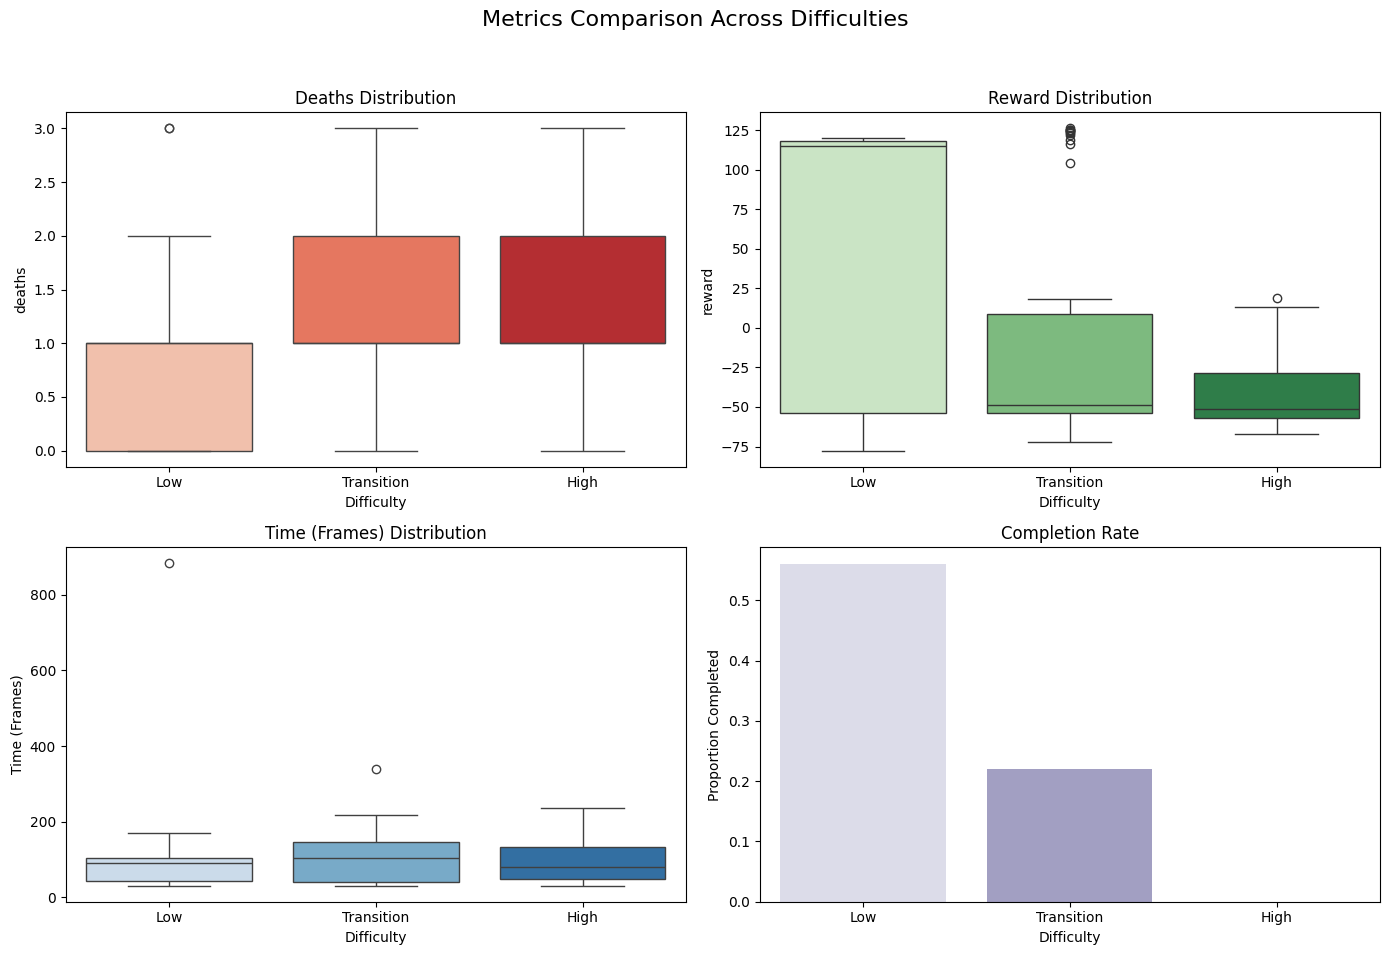

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define order for consistency
difficulty_order = ['Low', 'Transition', 'High']

# Initialize figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Metrics Comparison Across Difficulties', fontsize=16)

# 1. Deaths Distribution
sns.boxplot(data=df_metrics, x='Difficulty', y='deaths', order=difficulty_order, ax=axes[0, 0], palette='Reds')
axes[0, 0].set_title('Deaths Distribution')

# 2. Reward Distribution
sns.boxplot(data=df_metrics, x='Difficulty', y='reward', order=difficulty_order, ax=axes[0, 1], palette='Greens')
axes[0, 1].set_title('Reward Distribution')

# 3. Time (Frames) Distribution
sns.boxplot(data=df_metrics, x='Difficulty', y='frames', order=difficulty_order, ax=axes[1, 0], palette='Blues')
axes[1, 0].set_title('Time (Frames) Distribution')
axes[1, 0].set_ylabel('Time (Frames)')

# 4. Completion Rate
# Calculate mean completion rate for barplot
sns.barplot(data=df_metrics, x='Difficulty', y='completed', order=difficulty_order, ax=axes[1, 1], palette='Purples', errorbar=None)
axes[1, 1].set_title('Completion Rate')
axes[1, 1].set_ylabel('Proportion Completed')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Reasoning**:
The previous code execution produced FutureWarnings because `palette` was passed to seaborn functions without assigning `hue`. I will update the plotting commands to assign `x` to `hue` and set `legend=False` as recommended by the warning message to ensure clean execution and future compatibility.



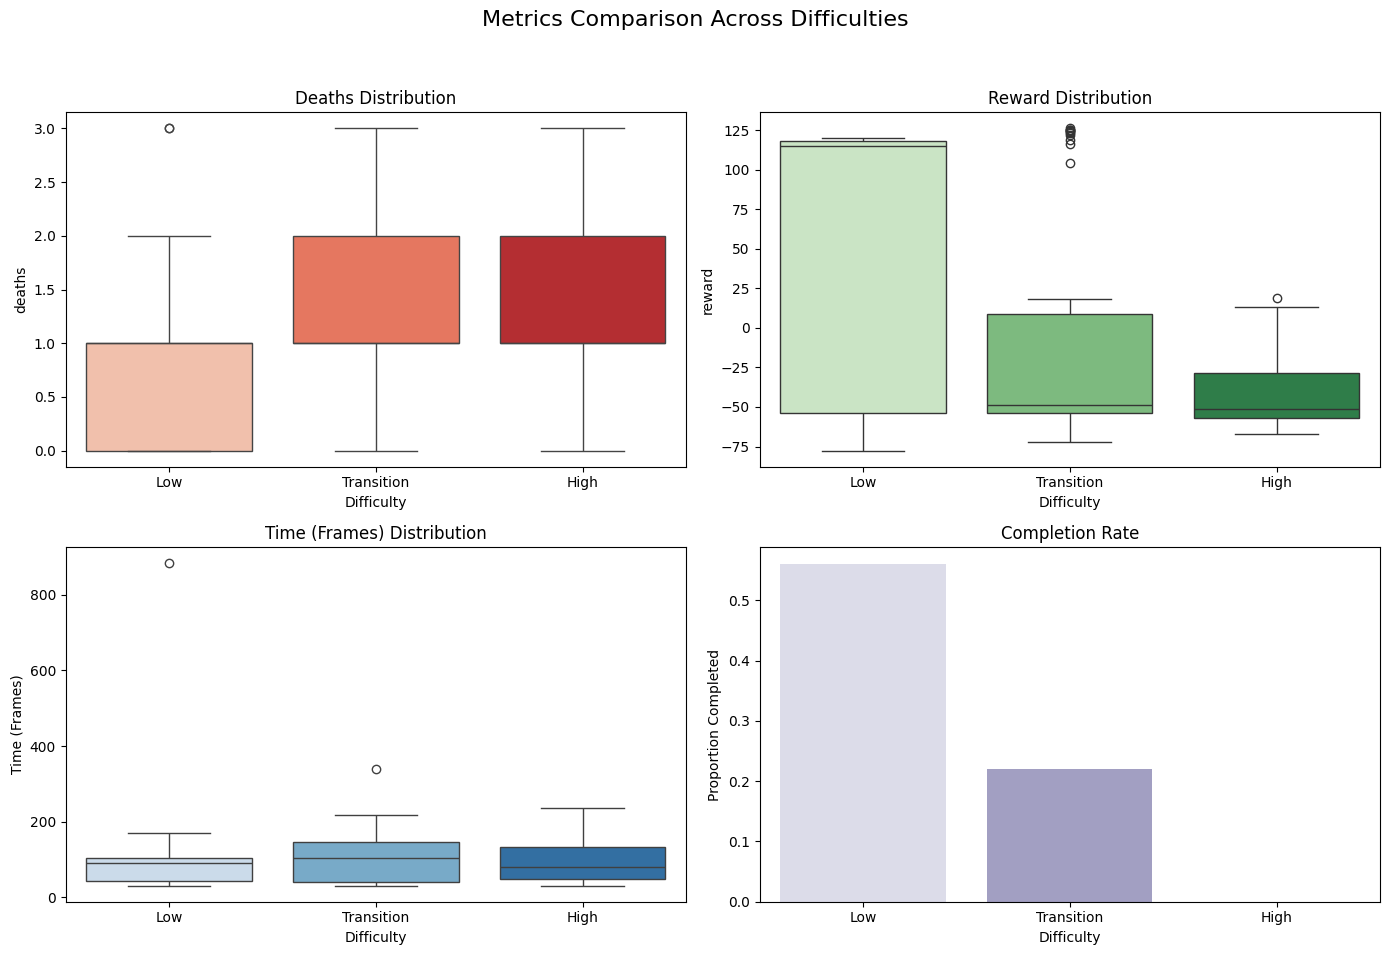

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define order for consistency
difficulty_order = ['Low', 'Transition', 'High']

# Initialize figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Metrics Comparison Across Difficulties', fontsize=16)

# 1. Deaths Distribution
sns.boxplot(data=df_metrics, x='Difficulty', y='deaths', order=difficulty_order, hue='Difficulty', ax=axes[0, 0], palette='Reds', legend=False)
axes[0, 0].set_title('Deaths Distribution')

# 2. Reward Distribution
sns.boxplot(data=df_metrics, x='Difficulty', y='reward', order=difficulty_order, hue='Difficulty', ax=axes[0, 1], palette='Greens', legend=False)
axes[0, 1].set_title('Reward Distribution')

# 3. Time (Frames) Distribution
sns.boxplot(data=df_metrics, x='Difficulty', y='frames', order=difficulty_order, hue='Difficulty', ax=axes[1, 0], palette='Blues', legend=False)
axes[1, 0].set_title('Time (Frames) Distribution')
axes[1, 0].set_ylabel('Time (Frames)')

# 4. Completion Rate
# Calculate mean completion rate for barplot
sns.barplot(data=df_metrics, x='Difficulty', y='completed', order=difficulty_order, hue='Difficulty', ax=axes[1, 1], palette='Purples', errorbar=None, legend=False)
axes[1, 1].set_title('Completion Rate')
axes[1, 1].set_ylabel('Proportion Completed')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Reasoning**:
Calculate and display summary statistics (count, mean, standard deviation) for the key metrics ('deaths', 'reward', 'frames', 'completed') grouped by 'Difficulty'. This will provide the numerical basis for the final analysis.



In [6]:
summary_stats = df_metrics.groupby('Difficulty')[['deaths', 'reward', 'frames', 'completed']].agg(['count', 'mean', 'std'])

# Reorder index to match logical progression
summary_stats = summary_stats.reindex(['Low', 'Transition', 'High'])

print("Summary Statistics by Difficulty Level:")
display(summary_stats)

Summary Statistics by Difficulty Level:


deaths                 reward                       frames          \
            count  mean       std  count       mean        std  count    mean   
Difficulty                                                                      
Low            50  0.62  0.725343     50  42.359600  86.027363     50   97.06   
Transition     50  1.14  0.903734     50  -7.686640  71.708147     50  104.06   
High           50  1.40  1.049781     50 -38.955424  24.871890     50   95.80   

                       completed                  
                   std     count  mean       std  
Difficulty                                        
Low         118.399947        50  0.56  0.501427  
Transition   66.652131        50  0.22  0.418452  
High         53.490415        50  0.00  0.000000